<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
from tqdm import tqdm

import numpy as np

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import torch.nn.functional as F

from torchaudio import datasets
from torchaudio import transforms

import matplotlib.pyplot as plt

import IPython.display as ipd
import ssl

from torch.utils.data import Dataset, DataLoader

E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\extension\extension.py:14: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')
E:\Users\alex\anaconda3\envs\mil\lib\site-packages\torchaudio\backend\utils.py:64: UserWarning: The interface of "soundfile" backend is planned to change in 0.8.0 to match that of "sox_io" backend and the current interface will be removed in 0.9.0. To use the new interface, do `torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE = False` before setting the backend to "soundfile". Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  'The interface of "soundfile" backend is planned to change in 0.8.0 to '


In [2]:
print(torch.cuda.is_available())
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

ssl._create_default_https_context = ssl._create_unverified_context
dataset = datasets.VCTK_092(root="data", download=False)

ds_size = len(dataset)
train_i = int(0.1*ds_size)
train_i += train_i%2
val_i = int(0.11*ds_size) - train_i
val_i += val_i%2
test_i = ds_size - train_i - val_i
train_i, val_i, test_i, train_i + val_i + test_i == ds_size

train_ds, val_ds, test_ds = random_split(dataset, lengths=[train_i, val_i, test_i],
                                         generator=torch.Generator().manual_seed(42))

bs = 1
sr = 48000
sampleSize = 2048*2

def pad_collate(batch):
    (xx, _, _, _, _) = zip(*batch)
    xx = [x.squeeze() for x in xx]
#     print(xx[0].shape)
    xx_pad = pad_sequence(xx, batch_first=True, padding_value=0).unsqueeze(1)
#     print(xx_pad.shape)

    return xx_pad

True


In [3]:
train_i, val_i, test_i, train_i + val_i + test_i == ds_size

(4388, 438, 39047, True)

In [78]:
def get_data(train_ds, val_ds, test_ds, bs):
    return (
         DataLoader(train_ds, batch_size=bs, collate_fn=pad_collate, shuffle=True), 
         DataLoader(val_ds, batch_size=2 * bs, collate_fn=pad_collate), 
         DataLoader(test_ds, batch_size=2 * bs, collate_fn=pad_collate),
    )

def preprocess(x):
    ns = int(((((x.shape[1]/HOP_LENGTH-4)/2-3)/2-1)/2-1)/2)
    ns = int(((((ns*2+1)*2+1)*2+3)*2+4)*HOP_LENGTH)
    x = x.narrow(1, 0, ns)
    x = torch.stft(input=x, n_fft=N_FFT, 
                          hop_length=HOP_LENGTH, normalized=True)
    x = x.narrow(2, 0, x.shape[2]-1)
    x = x.unsqueeze(1)
#     print(x.shape)
    return x.to(dev)

class WrappedDataLoader:
    def __init__(self, dl, func):
        self.dl = dl
        self.func = func

    def __len__(self):
        return len(self.dl)

    def __iter__(self):
        batches = iter(self.dl)
        for b in batches:
#             if len(b.shape) == 3:
#                 b = b.unsqueeze(0)
            inter = torch.stft(b.squeeze(), n_fft=2048, return_complex=True)
            if len(inter.shape) == 2:
                inter = inter.unsqueeze(0)
#             print(inter.shape)
#             print(b.shape)
            a = int(inter.shape[0] * inter.shape[1] * inter.shape[2] *2)
            d0 = torch.randint(inter.shape[0], (1, a))
            d1 = torch.randint(inter.shape[1], (1, a))
            d2 = torch.randint(inter.shape[2], (1, a))
            ll = torch.cat((d0, d1, d2)).numpy()
            inter[ll] = 0
            x = torch.istft(inter, n_fft=2048)
            x_noisy, y_true = self.func(x), self.func(b.squeeze(1))
            if x_noisy.shape[3] < y_true.shape[3]:
#                 print(x_noisy.shape, y_true.shape)
                y_true = y_true.narrow(3, 0, x_noisy.shape[3])
            yield (x_noisy, y_true)

train_dl, val_dl, test_dl = get_data(train_ds, val_ds, test_ds, bs)
train_dl = WrappedDataLoader(train_dl, preprocess)
val_dl = WrappedDataLoader(val_dl, preprocess)
test_dl = WrappedDataLoader(test_dl, preprocess)

In [5]:
DEVICE = dev
SAMPLE_RATE = 48000
N_FFT = SAMPLE_RATE * 64 // 1000 + 4
HOP_LENGTH = SAMPLE_RATE * 16 // 1000 + 4
N_FFT, HOP_LENGTH

(3076, 772)

In [37]:
x = next(iter(train_dl))

In [38]:
x[0].shape

torch.Size([1, 1, 1539, 214, 2])

In [52]:
x[0].shape

torch.Size([2, 1539, 342, 2])

In [49]:
x[0].shape

torch.Size([4, 1539, 279, 2])

In [6]:
class SpeechDataset(Dataset):
    """
    A dataset class with audio that cuts them/paddes them to a specified length, applies a Short-tome Fourier transform,
    normalizes and leads to a tensor.
    """
    def __init__(self, noisy_files, clean_files, n_fft=64, hop_length=16):
        super().__init__()
        # list of files
        self.noisy_files = sorted(noisy_files)
        self.clean_files = sorted(clean_files)
        
        # stft parameters
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        self.len_ = len(self.noisy_files)
        
        # fixed len
        self.max_len = 165000

    
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        waveform, _ = torchaudio.load(file)
        return waveform
  
    def __getitem__(self, index):
        # load to tensors and normalization
        x_clean = self.load_sample(self.clean_files[index])
        x_noisy = self.load_sample(self.noisy_files[index])
        
        # padding/cutting
        x_clean = self._prepare_sample(x_clean)
        x_noisy = self._prepare_sample(x_noisy)
        
        # Short-time Fourier transform
        x_noisy_stft = torch.stft(input=x_noisy, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        x_clean_stft = torch.stft(input=x_clean, n_fft=self.n_fft, 
                                  hop_length=self.hop_length, normalized=True)
        
        return x_noisy_stft, x_clean_stft
        
    def _prepare_sample(self, waveform):
        waveform = waveform.numpy()
        current_len = waveform.shape[1]
        
        output = np.zeros((1, self.max_len), dtype='float32')
        output[0, -current_len:] = waveform[0, :self.max_len]
        output = torch.from_numpy(output)
        
        return output

In [7]:
class CConv2d(nn.Module):
    """
    Class of complex valued convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding=0):
        super().__init__()
        
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.padding = padding
        self.stride = stride
        
        self.real_conv = nn.Conv2d(in_channels=self.in_channels, 
                                   out_channels=self.out_channels, 
                                   kernel_size=self.kernel_size, 
                                   padding=self.padding, 
                                   stride=self.stride)
        
        self.im_conv = nn.Conv2d(in_channels=self.in_channels, 
                                 out_channels=self.out_channels, 
                                 kernel_size=self.kernel_size, 
                                 padding=self.padding, 
                                 stride=self.stride)
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_conv.weight)
        nn.init.xavier_uniform_(self.im_conv.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        c_real = self.real_conv(x_real) - self.im_conv(x_im)
        c_im = self.im_conv(x_real) + self.real_conv(x_im)
        
        output = torch.stack([c_real, c_im], dim=-1)
        return output
    
class CConvTranspose2d(nn.Module):
    """
      Class of complex valued dilation convolutional layer
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride, output_padding=0, padding=0):
        super().__init__()
        
        self.in_channels = in_channels

        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.output_padding = output_padding
        self.padding = padding
        self.stride = stride
        
        self.real_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding,
                                            padding=self.padding,
                                            stride=self.stride)
        
        self.im_convt = nn.ConvTranspose2d(in_channels=self.in_channels, 
                                            out_channels=self.out_channels, 
                                            kernel_size=self.kernel_size, 
                                            output_padding=self.output_padding, 
                                            padding=self.padding,
                                            stride=self.stride)
        
        
        # Glorot initialization.
        nn.init.xavier_uniform_(self.real_convt.weight)
        nn.init.xavier_uniform_(self.im_convt.weight)
        
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        ct_real = self.real_convt(x_real) - self.im_convt(x_im)
        ct_im = self.im_convt(x_real) + self.real_convt(x_im)
        
        output = torch.stack([ct_real, ct_im], dim=-1)
        return output
    
class CBatchNorm2d(nn.Module):
    """
    Class of complex valued batch normalization layer
    """
    def __init__(self, num_features, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True):
        super().__init__()
        
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum
        self.affine = affine
        self.track_running_stats = track_running_stats
        
        self.real_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                      affine=self.affine, track_running_stats=self.track_running_stats)
        self.im_b = nn.BatchNorm2d(num_features=self.num_features, eps=self.eps, momentum=self.momentum,
                                    affine=self.affine, track_running_stats=self.track_running_stats) 
        
    def forward(self, x):
        x_real = x[..., 0]
        x_im = x[..., 1]
        
        n_real = self.real_b(x_real)
        n_im = self.im_b(x_im)  
        
        output = torch.stack([n_real, n_im], dim=-1)
        return output
    
class Encoder(nn.Module):
    """
    Class of upsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45, padding=(0,0)):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.padding = padding

        self.cconv = CConv2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconv(x)
        normed = self.cbn(conved)
        acted = self.leaky_relu(normed)
        
        return acted
    
class Decoder(nn.Module):
    """
    Class of downsample block
    """
    def __init__(self, filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45,
                 output_padding=(0,0), padding=(0,0), last_layer=False):
        super().__init__()
        
        self.filter_size = filter_size
        self.stride_size = stride_size
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.output_padding = output_padding
        self.padding = padding
        
        self.last_layer = last_layer
        
        self.cconvt = CConvTranspose2d(in_channels=self.in_channels, out_channels=self.out_channels, 
                             kernel_size=self.filter_size, stride=self.stride_size, output_padding=self.output_padding, padding=self.padding)
        
        self.cbn = CBatchNorm2d(num_features=self.out_channels) 
        
        self.leaky_relu = nn.LeakyReLU()
            
    def forward(self, x):
        
        conved = self.cconvt(x)
        
        if not self.last_layer:
            normed = self.cbn(conved)
            output = self.leaky_relu(normed)
        else:
            m_phase = conved / (torch.abs(conved) + 1e-8)
            m_mag = torch.tanh(torch.abs(conved))
            output = m_phase * m_mag
            
        return output    

In [8]:
class DCUnet10(nn.Module):
    """
    Deep Complex U-Net class of the model.
    """
    def __init__(self, n_fft=64, hop_length=16):
        super().__init__()
        
        # for istft
        self.n_fft = n_fft
        self.hop_length = hop_length
        
        # downsampling/encoding
        self.downsample0 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=1, out_channels=45)
        self.downsample1 = Encoder(filter_size=(7,5), stride_size=(2,2), in_channels=45, out_channels=90)
        self.downsample2 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample3 = Encoder(filter_size=(5,3), stride_size=(2,2), in_channels=90, out_channels=90)
        self.downsample4 = Encoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        
        # upsampling/decoding
        self.upsample0 = Decoder(filter_size=(5,3), stride_size=(2,1), in_channels=90, out_channels=90)
        self.upsample1 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90, output_padding=(0,0))
        self.upsample2 = Decoder(filter_size=(5,3), stride_size=(2,2), in_channels=180, out_channels=90)
        self.upsample3 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=180, out_channels=45, output_padding=(0,0))
        self.upsample4 = Decoder(filter_size=(7,5), stride_size=(2,2), in_channels=90, output_padding=(0,1), out_channels=1, last_layer=True)
        
        
    def forward(self, x, is_istft=True):
#         print(x.shape)
        # downsampling/encoding
        d0 = self.downsample0(x)
        d1 = self.downsample1(d0) 
        d2 = self.downsample2(d1)        
        d3 = self.downsample3(d2)        
        d4 = self.downsample4(d3)
        
        # upsampling/decoding 
        u0 = self.upsample0(d4)
        # skip-connection
        c0 = torch.cat((u0, d3), dim=1)
        
        u1 = self.upsample1(c0)
        c1 = torch.cat((u1, d2), dim=1)
        
        u2 = self.upsample2(c1)
        c2 = torch.cat((u2, d1), dim=1)
        
        u3 = self.upsample3(c2)
        c3 = torch.cat((u3, d0), dim=1)
        
        u4 = self.upsample4(c3)
        
        # u4 - the mask
        if x.shape[3] < u4.shape[3]:
            x = F.pad(x, (0,0,0,1))
        if u4.shape[3] < x.shape[3]:
            x = x.narrow(3, 0, u4.shape[3])            
#         print(u4.shape, x.shape)
        output = u4 * x
        if is_istft:
            output = torch.squeeze(output, 1)
            output = torch.istft(output, n_fft=self.n_fft, hop_length=self.hop_length, normalized=True)
        
        return output

In [9]:
y = x[0]
# y.narrow()
print(y.shape)
z = F.pad(y, (0,0,0,1))
z.shape

NameError: name 'x' is not defined

In [39]:
z[0,:,1,0]

tensor([ 5.1259e-03,  1.5667e-03,  6.8436e-03,  ...,  3.1261e-05,
        -3.7434e-06, -1.1433e-04], device='cuda:0')

In [10]:
def wsdr_fn(x_, y_pred_, y_true_, eps=1e-8):
    # to time-domain waveform
    y_true_ = torch.squeeze(y_true_, 1)
    x_ = torch.squeeze(x_, 1)
    y_true = torch.istft(y_true_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
    x = torch.istft(x_, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
#     print(y_true_.shape, x_.shape)
#     print(y_true.shape, x.shape)

    y_pred = y_pred_.flatten(1)
    y_true = y_true.flatten(1)
    x = x.flatten(1)


    def sdr_fn(true, pred, eps=1e-8):
        num = torch.sum(true * pred, dim=1)
        den = torch.norm(true, p=2, dim=1) * torch.norm(pred, p=2, dim=1)
        return -(num / (den + eps))

    # true and estimated noise
    z_true = x - y_true
    z_pred = x - y_pred

    a = torch.sum(y_true**2, dim=1) / (torch.sum(y_true**2, dim=1) + torch.sum(z_true**2, dim=1) + eps)
    wSDR = a * sdr_fn(y_true, y_pred) + (1 - a) * sdr_fn(z_true, z_pred)
    return torch.mean(wSDR)

def train_epoch(net, train_loader, loss_fn, optimizer):
    net.train()
    train_ep_loss = 0.
    counter = 0
    for batch_idx, (noisy_x, clean_x) in enumerate(train_loader):
        if batch_idx % 100 == 99:
            print(batch_idx, "/", train_i//bs, train_ep_loss / counter)

        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)

        # zero  gradients
        net.zero_grad()

        # get the output from the model
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        loss.backward()
        optimizer.step()

        train_ep_loss += loss.item() 
        counter += 1

    train_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    return train_ep_loss

def test_epoch(net, test_loader, loss_fn):
    net.eval()
    test_ep_loss = 0.
    counter = 0.
    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x, clean_x = noisy_x.to(DEVICE), clean_x.to(DEVICE)
        pred_x = net(noisy_x)

        # calculate loss
        loss = loss_fn(noisy_x, pred_x, clean_x)
        test_ep_loss += loss.item() 
        
        counter += 1

    test_ep_loss /= counter

    # clear cache
    gc.collect()
    torch.cuda.empty_cache()
    
    return test_ep_loss

def train(net, train_loader, test_loader, loss_fn, optimizer, scheduler, epochs):
    
    train_losses = []
    test_losses = []

    for e in tqdm(range(epochs)):

        # first evaluating for comparison
        if e == 0:
            with torch.no_grad():
                test_loss = test_epoch(net, test_loader, loss_fn)
                
            test_losses.append(test_loss)
            print("Loss before training:{:.6f}".format(test_loss))
          

        train_loss = train_epoch(net, train_loader, loss_fn, optimizer)
#         scheduler.step()
        with torch.no_grad():
            test_loss = test_epoch(net, test_loader, loss_fn)

        train_losses.append(train_loss)
        test_losses.append(test_loss)

        # clear cache
        torch.cuda.empty_cache()
        gc.collect()

        print("Epoch: {}/{}...".format(e+1, epochs),
                      "Loss: {:.6f}...".format(train_loss),
                      "Test Loss: {:.6f}".format(test_loss))
    return train_losses, test_losses

def pesq_score(net, test_loader):
    net.eval()
    test_pesq = 0.
    counter = 0.


    for noisy_x, clean_x in test_loader:
        # get the output from the model
        noisy_x = noisy_x.to(DEVICE)
        with torch.no_grad():
            pred_x = net(noisy_x)
        clean_x = torch.squeeze(clean_x, 1)
        clean_x = torch.istft(clean_x, n_fft=N_FFT, hop_length=HOP_LENGTH, normalized=True)
        
        
        psq = 0.
        for i in range(len(clean_x)):
            clean_x_16 = torchaudio.transforms.Resample(48000, 16000)(clean_x[i, 0,:].view(1,-1))
            pred_x_16 = torchaudio.transforms.Resample(48000, 16000)(pred_x[i, 0,:].view(1,-1))

            clean_x_16 = clean_x_16.cpu().cpu().numpy()
            pred_x_16 = pred_x_16.detach().cpu().numpy()
            
            
            
            psq += pesq(clean_x_16.flatten(), pred_x_16.flatten(), 16000)
            
        psq /= len(clean_x)
        test_pesq += psq
        counter += 1

    test_pesq /= counter 
    return test_pesq

In [11]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [12]:
dcunet10 = DCUnet10(N_FFT, HOP_LENGTH).to(DEVICE)

In [13]:
loss_fn = wsdr_fn
# optimizer = torch.optim.Adam(dcunet10.parameters(), lr=1e-4)
optimizer = torch.optim.Adadelta(dcunet10.parameters())
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

In [16]:
train_losses, test_losses = train(dcunet10, train_dl, val_dl, loss_fn, optimizer, scheduler, 100)

  0%|                                                                                          | 0/100 [00:00<?, ?it/s]

Loss before training:0.711088
99 / 4388 -0.5519165884364735
199 / 4388 -0.5607056843875041
299 / 4388 -0.5649345875982457
399 / 4388 -0.5678779953404477
499 / 4388 -0.5691962633319274
599 / 4388 -0.5703623170944208
699 / 4388 -0.5710440751735404
799 / 4388 -0.5718509469820053
899 / 4388 -0.5720806896222447
999 / 4388 -0.5722940968977915
1099 / 4388 -0.5723052679733106
1199 / 4388 -0.5725991490535481
1299 / 4388 -0.5727534991810191
1399 / 4388 -0.5727440084918556
1499 / 4388 -0.5731939876811197
1599 / 4388 -0.5731009431858969
1699 / 4388 -0.5734136636605187
1799 / 4388 -0.5733945370383101
1899 / 4388 -0.5735084423741396
1999 / 4388 -0.5737403858864886
2099 / 4388 -0.573776933239891
2199 / 4388 -0.5738524021669754
2299 / 4388 -0.5737913620891961
2399 / 4388 -0.5739394115775562
2499 / 4388 -0.5740343038679935
2599 / 4388 -0.5742324283486286
2699 / 4388 -0.5743220405761469
2799 / 4388 -0.5742395144779795
2899 / 4388 -0.5741772748306316
2999 / 4388 -0.5743310752213896
3099 / 4388 -0.5743978

  1%|▊                                                                             | 1/100 [12:28<20:35:17, 748.66s/it]

Epoch: 1/100... Loss: -0.575405... Test Loss: -0.579795
99 / 4388 -0.5782905603298033
199 / 4388 -0.5763735170639939
299 / 4388 -0.5778392825437628
399 / 4388 -0.5775314322240969
499 / 4388 -0.5778059532384356
599 / 4388 -0.5775591586288904
699 / 4388 -0.5774687257873824
799 / 4388 -0.5776347189358387
899 / 4388 -0.5779681992742987
999 / 4388 -0.5776433148780266
1099 / 4388 -0.5778377672235352
1199 / 4388 -0.5775670686595334
1299 / 4388 -0.577600279709667
1399 / 4388 -0.5777266539787718
1499 / 4388 -0.577812276139428
1599 / 4388 -0.5776318956755936
1699 / 4388 -0.5775786789990369
1799 / 4388 -0.5772913156647759
1899 / 4388 -0.5773810235182193
1999 / 4388 -0.5773532845158169
2099 / 4388 -0.5772961217940222
2199 / 4388 -0.5774552378398605
2299 / 4388 -0.5775809477027887
2399 / 4388 -0.5774467539146275
2499 / 4388 -0.5773151797764585
2599 / 4388 -0.5774823920159855
2699 / 4388 -0.5773587980483276
2799 / 4388 -0.5774617160418579
2899 / 4388 -0.5773960123312148
2999 / 4388 -0.57737744180470

  2%|█▌                                                                            | 2/100 [24:18<19:45:45, 725.98s/it]

Epoch: 2/100... Loss: -0.577173... Test Loss: -0.577728
99 / 4388 -0.5757323271698422
199 / 4388 -0.5797492000625362
299 / 4388 -0.5801747384478018
399 / 4388 -0.5796659208628767
499 / 4388 -0.5797808369797074
599 / 4388 -0.5800046499364563
699 / 4388 -0.5802146862334278
799 / 4388 -0.5794469874552701
899 / 4388 -0.5796303039000217
999 / 4388 -0.5793759198160143
1099 / 4388 -0.5791117529689018
1199 / 4388 -0.5787719161287758
1299 / 4388 -0.5786930385280151
1399 / 4388 -0.5788017469401697
1499 / 4388 -0.5787771009182119
1599 / 4388 -0.5788118387849127
1699 / 4388 -0.5791531272535116
1799 / 4388 -0.5791461268122028
1899 / 4388 -0.5791968036444957
1999 / 4388 -0.5792738523496396
2099 / 4388 -0.5793760463048754
2199 / 4388 -0.5793466234055363
2299 / 4388 -0.5793913592199182
2399 / 4388 -0.5793649143057596
2499 / 4388 -0.5795467789528989
2599 / 4388 -0.5794694185623896
2699 / 4388 -0.5796674641360615
2799 / 4388 -0.5796963488919346
2899 / 4388 -0.5797197221784437
2999 / 4388 -0.579825497371

  3%|██▎                                                                           | 3/100 [36:08<19:21:50, 718.66s/it]

Epoch: 3/100... Loss: -0.579664... Test Loss: -0.576390
99 / 4388 -0.5831988736836597
199 / 4388 -0.5814102933035424
299 / 4388 -0.580392422285367
399 / 4388 -0.5808682434989098
499 / 4388 -0.5803364668198243
599 / 4388 -0.5799990206310068
699 / 4388 -0.5798843918269625
799 / 4388 -0.5797589372782892
899 / 4388 -0.579374772058313
999 / 4388 -0.5797157206752518
1099 / 4388 -0.5795725630401372
1199 / 4388 -0.5796807677523109
1299 / 4388 -0.5798584524028755
1399 / 4388 -0.579621903230839
1499 / 4388 -0.5796634110710953
1599 / 4388 -0.5799729090470535
1699 / 4388 -0.5797253501562598
1799 / 4388 -0.5798987478531354
1899 / 4388 -0.5799056578774776
1999 / 4388 -0.5800429576930551
2099 / 4388 -0.579978911237185
2199 / 4388 -0.5799223990427358
2299 / 4388 -0.5800201934075656
2399 / 4388 -0.5800058158699201
2499 / 4388 -0.5800709664559259
2599 / 4388 -0.5800289386233352
2699 / 4388 -0.5801741606264301
2799 / 4388 -0.5800397981699554
2899 / 4388 -0.5800389281816835
2999 / 4388 -0.5800445254602683

  4%|███                                                                           | 4/100 [47:59<19:04:49, 715.52s/it]

Epoch: 4/100... Loss: -0.579289... Test Loss: -0.581529
99 / 4388 -0.5810646721811006
199 / 4388 -0.5791775063054645
299 / 4388 -0.5786658964029523
399 / 4388 -0.5786188209714148
499 / 4388 -0.5781975413611036
599 / 4388 -0.5784716480761418
699 / 4388 -0.5789814373965939
799 / 4388 -0.5787571805514143
899 / 4388 -0.578944841667065
999 / 4388 -0.5789200651037084
1099 / 4388 -0.5788737436768355
1199 / 4388 -0.5790839820627971
1299 / 4388 -0.5788790814182775
1399 / 4388 -0.5790186114742383
1499 / 4388 -0.5788282289196445
1599 / 4388 -0.578570860970982
1699 / 4388 -0.5787501757709049
1799 / 4388 -0.5788542176532109
1899 / 4388 -0.5789025228955107
1999 / 4388 -0.5790433587432802
2099 / 4388 -0.5790565906961286
2199 / 4388 -0.5792530754741184
2299 / 4388 -0.5794449063190537
2399 / 4388 -0.5795412061735211
2499 / 4388 -0.5793292163705387
2599 / 4388 -0.5793491610888106
2699 / 4388 -0.579387850388636
2799 / 4388 -0.5795692603219276
2899 / 4388 -0.5796414426212765
2999 / 4388 -0.579662080534937

  5%|███▉                                                                          | 5/100 [59:48<18:49:09, 713.15s/it]

Epoch: 5/100... Loss: -0.579349... Test Loss: -0.579037
99 / 4388 -0.5812089015739133
199 / 4388 -0.5789187245033495
299 / 4388 -0.5772995855098584
399 / 4388 -0.5773227352247501
499 / 4388 -0.5772845826311437
599 / 4388 -0.5775971678342167
699 / 4388 -0.5768463700284944
799 / 4388 -0.5773286834377819
899 / 4388 -0.5783572676980058
999 / 4388 -0.5783545642166406
1099 / 4388 -0.5779918554807598
1199 / 4388 -0.5784270843433479
1299 / 4388 -0.5783525382536389
1399 / 4388 -0.578513777281575
1499 / 4388 -0.5785231140750977
1599 / 4388 -0.5786720262123988
1699 / 4388 -0.5786919754662887
1799 / 4388 -0.5785294873738303
1899 / 4388 -0.57866329682884
1999 / 4388 -0.5785664399454986
2099 / 4388 -0.5786454507911586
2199 / 4388 -0.5785905214508538
2299 / 4388 -0.5786381004400075
2399 / 4388 -0.5786183134572314
2499 / 4388 -0.5784923115602824
2599 / 4388 -0.5787362029181852
2699 / 4388 -0.5788610277241272
2799 / 4388 -0.5787328316425161
2899 / 4388 -0.578648455782815
2999 / 4388 -0.5787374604221343

  6%|████▌                                                                       | 6/100 [1:11:38<18:35:53, 712.27s/it]

Epoch: 6/100... Loss: -0.578898... Test Loss: -0.578571
99 / 4388 -0.5856814348336422
199 / 4388 -0.5821769905449757
299 / 4388 -0.5808992037007641
399 / 4388 -0.580294552452881
499 / 4388 -0.5796480570623057
599 / 4388 -0.5792496125765755
699 / 4388 -0.5790370922743506
799 / 4388 -0.579564773917049
899 / 4388 -0.5797294441266638
999 / 4388 -0.5794254888941696
1099 / 4388 -0.5796337234800354
1199 / 4388 -0.5790366211267588
1299 / 4388 -0.5788253261732816
1399 / 4388 -0.5790435495846948
1499 / 4388 -0.5790653701143474
1599 / 4388 -0.5791865496280567
1699 / 4388 -0.5791733424196249
1799 / 4388 -0.5791761600156172
1899 / 4388 -0.5792579868393487
1999 / 4388 -0.5792428679976719
2099 / 4388 -0.5794139972126103
2199 / 4388 -0.5793309773353622
2299 / 4388 -0.5794423000353116
2399 / 4388 -0.5794467036676387
2499 / 4388 -0.5793379987655234
2599 / 4388 -0.5794680715753923
2699 / 4388 -0.5795509092407608
2799 / 4388 -0.5796137396119756
2899 / 4388 -0.579678197468754
2999 / 4388 -0.579683179794132

  7%|█████▎                                                                      | 7/100 [1:23:30<18:23:46, 712.11s/it]

Epoch: 7/100... Loss: -0.579837... Test Loss: -0.579978
99 / 4388 -0.5794113013479445
199 / 4388 -0.5780115175486809
299 / 4388 -0.5791124597839687
399 / 4388 -0.5797658777774725
499 / 4388 -0.5807407323965329
599 / 4388 -0.5806261678171875
699 / 4388 -0.5804496805725862
799 / 4388 -0.5805824659345147
899 / 4388 -0.5806623470531289
999 / 4388 -0.5804220203522805
1099 / 4388 -0.5809241154716707
1199 / 4388 -0.5807095554791658
1299 / 4388 -0.5807144356471378
1399 / 4388 -0.5809794430054452
1499 / 4388 -0.5807860981750043
1599 / 4388 -0.5807111373053557
1699 / 4388 -0.5806398615197198
1799 / 4388 -0.5807464873545564
1899 / 4388 -0.5807145214068256
1999 / 4388 -0.5808622510866143
2099 / 4388 -0.5807345172034496
2199 / 4388 -0.5809824737081098
2299 / 4388 -0.5811427647183904
2399 / 4388 -0.5811091598221142
2499 / 4388 -0.5809360593736244
2599 / 4388 -0.5810507278847851
2699 / 4388 -0.5811029167341365
2799 / 4388 -0.5811682489140624
2899 / 4388 -0.5810489093138869
2999 / 4388 -0.580897324043

  8%|██████                                                                      | 8/100 [1:35:24<18:12:54, 712.77s/it]

Epoch: 8/100... Loss: -0.580225... Test Loss: -0.583279
99 / 4388 -0.5808605696215774
199 / 4388 -0.582623727657088
299 / 4388 -0.5827372139911587
399 / 4388 -0.5813350070986831
499 / 4388 -0.5812172389221574
599 / 4388 -0.5802824366371301
699 / 4388 -0.5800763597560031
799 / 4388 -0.5801717577425202
899 / 4388 -0.5802624318769432
999 / 4388 -0.5802951164252765
1099 / 4388 -0.580377148676179
1199 / 4388 -0.5805329254659839
1299 / 4388 -0.5806230420190798
1399 / 4388 -0.5811100959394385
1499 / 4388 -0.5812050863812175
1599 / 4388 -0.5811641984726952
1699 / 4388 -0.5811512283783509
1799 / 4388 -0.5811739828501761
1899 / 4388 -0.5811922525562319
1999 / 4388 -0.5811115838904092
2099 / 4388 -0.5810282492478612
2199 / 4388 -0.5811147401689561
2299 / 4388 -0.5812743850483382
2399 / 4388 -0.5812747888562082
2499 / 4388 -0.5813130873854325
2599 / 4388 -0.581202093604988
2699 / 4388 -0.5809122418288436
2799 / 4388 -0.5810472474817124
2899 / 4388 -0.581063451315461
2999 / 4388 -0.5808803074933879

  9%|██████▊                                                                     | 9/100 [1:47:22<18:03:26, 714.36s/it]

Epoch: 9/100... Loss: -0.581028... Test Loss: -0.581599
99 / 4388 -0.5810601169412787
199 / 4388 -0.5823321367927532
299 / 4388 -0.5818164480171076
399 / 4388 -0.5813471653258293
499 / 4388 -0.5810802486353742
599 / 4388 -0.581242066343161
699 / 4388 -0.581212235324202
799 / 4388 -0.5811249037484204
899 / 4388 -0.5806997004353562
999 / 4388 -0.5806300635631378
1099 / 4388 -0.5807186208929769
1199 / 4388 -0.580363716902188
1299 / 4388 -0.5803162614550381
1399 / 4388 -0.5799891073376559
1499 / 4388 -0.579851542674676
1599 / 4388 -0.5799437391154091
1699 / 4388 -0.5801276738605757
1799 / 4388 -0.5801210243745669
1899 / 4388 -0.5800465941743012
1999 / 4388 -0.5801261649422791
2099 / 4388 -0.5803038538098619
2199 / 4388 -0.5803702174126424
2299 / 4388 -0.5803191813244515
2399 / 4388 -0.5803932638255792
2499 / 4388 -0.5805271175347504
2599 / 4388 -0.5804266715999198
2699 / 4388 -0.5803345303020463
2799 / 4388 -0.5803403112240118
2899 / 4388 -0.5802708492993732
2999 / 4388 -0.5803179926834888

 10%|███████▌                                                                   | 10/100 [1:59:15<17:50:57, 713.97s/it]

Epoch: 10/100... Loss: -0.580514... Test Loss: -0.579218
99 / 4388 -0.5835795119555309
199 / 4388 -0.585056699700092
299 / 4388 -0.5837351119637888
399 / 4388 -0.5829322747419352
499 / 4388 -0.5818947305182417
599 / 4388 -0.5821469603277407
699 / 4388 -0.5815030384984651
799 / 4388 -0.5819649551627931
899 / 4388 -0.5817167062117605
999 / 4388 -0.5810388046819288
1099 / 4388 -0.5811884524715933
1199 / 4388 -0.5812314664253699
1299 / 4388 -0.5813749651894191
1399 / 4388 -0.581463502295278
1499 / 4388 -0.5814130554364633
1599 / 4388 -0.5812373100928473
1699 / 4388 -0.5812418266139779
1799 / 4388 -0.5809208928644161
1899 / 4388 -0.5809903022739497
1999 / 4388 -0.5810354251513307
2099 / 4388 -0.5811040809235157
2199 / 4388 -0.5811266747454504
2299 / 4388 -0.5811076085559178
2399 / 4388 -0.5811447964677616
2499 / 4388 -0.5811859896036089
2599 / 4388 -0.5811982011395997
2699 / 4388 -0.5811584528153275
2799 / 4388 -0.5812207830190744
2899 / 4388 -0.5813145464907519
2999 / 4388 -0.5813257744030

 11%|████████▎                                                                  | 11/100 [2:11:06<17:37:39, 713.03s/it]

Epoch: 11/100... Loss: -0.581206... Test Loss: -0.580254
99 / 4388 -0.581494623362416
199 / 4388 -0.5806610671120074
299 / 4388 -0.5799512763485861
399 / 4388 -0.5822331342183259
499 / 4388 -0.5828991659538063
599 / 4388 -0.5825782510294938
699 / 4388 -0.5831517789070528
799 / 4388 -0.5823282576323451
899 / 4388 -0.5821070403888308
999 / 4388 -0.5823774513778266
1099 / 4388 -0.5822548348324422
1199 / 4388 -0.5824364722520734
1299 / 4388 -0.5825852002888299
1399 / 4388 -0.5826842000094203
1499 / 4388 -0.5827605695705401
1599 / 4388 -0.582205913192112
1699 / 4388 -0.582439006936066
1799 / 4388 -0.5825492779932928
1899 / 4388 -0.5822931842749969
1999 / 4388 -0.5821074275835685
2099 / 4388 -0.5822116725072229
2199 / 4388 -0.582205861129236
2299 / 4388 -0.5824052794257575
2399 / 4388 -0.5823158938445464
2499 / 4388 -0.5822616791119333
2599 / 4388 -0.5823235339662487
2699 / 4388 -0.5823978369944446
2799 / 4388 -0.5823480194702707
2899 / 4388 -0.5822669046835556
2999 / 4388 -0.582169193691235

 12%|█████████                                                                  | 12/100 [2:22:57<17:24:38, 712.26s/it]

Epoch: 12/100... Loss: -0.582197... Test Loss: -0.582121
99 / 4388 -0.5836282998624475
199 / 4388 -0.582296672777914
299 / 4388 -0.5816724061168556
399 / 4388 -0.5819295873319296
499 / 4388 -0.5821895407053655
599 / 4388 -0.5820332785978142
699 / 4388 -0.5827066997687022
799 / 4388 -0.5830845076763287
899 / 4388 -0.5830151299149362
999 / 4388 -0.5828449498485397
1099 / 4388 -0.5829325352233578
1199 / 4388 -0.5832520895097731
1299 / 4388 -0.5830532361260737
1399 / 4388 -0.5830205485299282
1499 / 4388 -0.5828334468257197
1599 / 4388 -0.5829553486892326
1699 / 4388 -0.5827973745829081
1799 / 4388 -0.5827442517772259
1899 / 4388 -0.5828742558953636
1999 / 4388 -0.5827666375713386
2099 / 4388 -0.5828262299597405
2199 / 4388 -0.5826807482749996
2299 / 4388 -0.5826066759370004
2399 / 4388 -0.5827012407054202
2499 / 4388 -0.5826173212801089
2599 / 4388 -0.5827172889692043
2699 / 4388 -0.582734833871404
2799 / 4388 -0.5826139082202489
2899 / 4388 -0.5826721743967419
2999 / 4388 -0.5824541673635

 13%|█████████▊                                                                 | 13/100 [2:34:47<17:11:48, 711.59s/it]

Epoch: 13/100... Loss: -0.582381... Test Loss: -0.581762
99 / 4388 -0.5863527914490363
199 / 4388 -0.5814795082238451
299 / 4388 -0.5818198526583388
399 / 4388 -0.5822216735447857
499 / 4388 -0.5825056290339851
599 / 4388 -0.5821835327029029
699 / 4388 -0.5822499533409042
799 / 4388 -0.5817706335023587
899 / 4388 -0.582036474125006
999 / 4388 -0.5824296378397249
1099 / 4388 -0.5825541752159216
1199 / 4388 -0.5825085680717423
1299 / 4388 -0.58250034392293
1399 / 4388 -0.582729522546246
1499 / 4388 -0.5828571165299877
1599 / 4388 -0.5828015806900105
1699 / 4388 -0.5830759559048141
1799 / 4388 -0.5829890042361184
1899 / 4388 -0.5829424069014394
1999 / 4388 -0.5829989422315833
2099 / 4388 -0.583007398675089
2199 / 4388 -0.5828688492174309
2299 / 4388 -0.5827512579308535
2399 / 4388 -0.5826931724005712
2499 / 4388 -0.5826558175564958
2599 / 4388 -0.5827578545281776
2699 / 4388 -0.5827512541781006
2799 / 4388 -0.5827662433501268
2899 / 4388 -0.5827247610829048
2999 / 4388 -0.5827411247535959

 14%|██████████▌                                                                | 14/100 [2:46:38<16:59:59, 711.62s/it]

Epoch: 14/100... Loss: -0.583024... Test Loss: -0.585992
99 / 4388 -0.5835122676810833
199 / 4388 -0.5840491513211523
299 / 4388 -0.5844111806373532
399 / 4388 -0.5829858326523525
499 / 4388 -0.5829376406922847
599 / 4388 -0.5831426159666854
699 / 4388 -0.5836892362913179
799 / 4388 -0.5832904594786027
899 / 4388 -0.582986245696351
999 / 4388 -0.5829644012856889
1099 / 4388 -0.5825494767265823
1199 / 4388 -0.5823519097406532
1299 / 4388 -0.5826449859729632
1399 / 4388 -0.58255201337421
1499 / 4388 -0.5824372882322918
1599 / 4388 -0.58250751353339
1699 / 4388 -0.5823621340117924
1799 / 4388 -0.5822991094965614
1899 / 4388 -0.5820527337393426
1999 / 4388 -0.5820832025146055
2099 / 4388 -0.5818389037809467
2199 / 4388 -0.5818707003356002
2299 / 4388 -0.5819911117162742
2399 / 4388 -0.5819339068570004
2499 / 4388 -0.582018581126966
2599 / 4388 -0.5820517978240729
2699 / 4388 -0.5821868774404169
2799 / 4388 -0.5820343350141804
2899 / 4388 -0.5821109548462963
2999 / 4388 -0.5821800805024602


 15%|███████████▎                                                               | 15/100 [2:58:27<16:46:48, 710.69s/it]

Epoch: 15/100... Loss: -0.582957... Test Loss: -0.582697
99 / 4388 -0.5825323877912579
199 / 4388 -0.580672722365988
299 / 4388 -0.582101047039032
399 / 4388 -0.5824433030341203
499 / 4388 -0.5827860089246639
599 / 4388 -0.58201009502793
699 / 4388 -0.5818277443086299
799 / 4388 -0.5826374416581084
899 / 4388 -0.5826753945119919
999 / 4388 -0.5830950018044587
1099 / 4388 -0.5830468531084451
1199 / 4388 -0.5832522813730979
1299 / 4388 -0.583391875785713
1399 / 4388 -0.5831269304866532
1499 / 4388 -0.5829612991267479
1599 / 4388 -0.583265388791005
1699 / 4388 -0.5831555462781649
1799 / 4388 -0.5828927358764618
1899 / 4388 -0.5829822269158969
1999 / 4388 -0.583002987475679
2099 / 4388 -0.5830516133097139
2199 / 4388 -0.5830297213811775
2299 / 4388 -0.5829166684683741
2399 / 4388 -0.5831464065418188
2499 / 4388 -0.5831664651095653
2599 / 4388 -0.5831308246759691
2699 / 4388 -0.5831561456039333
2799 / 4388 -0.5831914454240721
2899 / 4388 -0.5830677950452138
2999 / 4388 -0.58306232120602
309

 16%|████████████                                                               | 16/100 [3:10:18<16:35:03, 710.75s/it]

Epoch: 16/100... Loss: -0.583042... Test Loss: -0.583674
99 / 4388 -0.5828565750459228
199 / 4388 -0.57883932437729
299 / 4388 -0.5800159419061348
399 / 4388 -0.5796825858883392
499 / 4388 -0.5806238077924343
599 / 4388 -0.5804003228329259
699 / 4388 -0.5805958665491685
799 / 4388 -0.5804397274689919
899 / 4388 -0.5801936937319954
999 / 4388 -0.5799784314883006
1099 / 4388 -0.5802464800818168
1199 / 4388 -0.5802705158930803
1299 / 4388 -0.5803260307434983
1399 / 4388 -0.580326377173847
1499 / 4388 -0.5804021097645113
1599 / 4388 -0.58066728370051
1699 / 4388 -0.5809547188634239
1799 / 4388 -0.581089970401554
1899 / 4388 -0.5808057710018328
1999 / 4388 -0.5810421483405773
2099 / 4388 -0.5811427355721316
2199 / 4388 -0.5810999763776303
2299 / 4388 -0.5813818419690027
2399 / 4388 -0.5815492995881497
2499 / 4388 -0.5815838948876059
2599 / 4388 -0.5816318673920567
2699 / 4388 -0.581602073236941
2799 / 4388 -0.5817654771479422
2899 / 4388 -0.5817721813619035
2999 / 4388 -0.5817860586319656
3

 17%|████████████▊                                                              | 17/100 [3:22:08<16:22:58, 710.58s/it]

Epoch: 17/100... Loss: -0.582317... Test Loss: -0.581573
99 / 4388 -0.5845650669300195
199 / 4388 -0.5863257538733171
299 / 4388 -0.584403804313379
399 / 4388 -0.5842781220761158
499 / 4388 -0.5842146614868798
599 / 4388 -0.5844376595171544
699 / 4388 -0.5841902394236754
799 / 4388 -0.5840385792327016
899 / 4388 -0.5841099132552693
999 / 4388 -0.5841930064114483
1099 / 4388 -0.5840612302811391
1199 / 4388 -0.5839183292754796
1299 / 4388 -0.5844623267054099
1399 / 4388 -0.5841955655894167
1499 / 4388 -0.5842887736344989
1599 / 4388 -0.5843757109727018
1699 / 4388 -0.5841678023478647
1799 / 4388 -0.5839631695956771
1899 / 4388 -0.5837399134860659
1999 / 4388 -0.5837922510861039
2099 / 4388 -0.583653576604635
2199 / 4388 -0.5837946572510857
2299 / 4388 -0.5837464771772686
2399 / 4388 -0.583707558780772
2499 / 4388 -0.5836344386826233
2599 / 4388 -0.5838968994847716
2699 / 4388 -0.5839698716595068
2799 / 4388 -0.5837693144462499
2899 / 4388 -0.5838176179503769
2999 / 4388 -0.58387756976694

 18%|█████████████▌                                                             | 18/100 [3:33:58<16:11:01, 710.50s/it]

Epoch: 18/100... Loss: -0.583979... Test Loss: -0.581763
99 / 4388 -0.5807904020102337
199 / 4388 -0.5823024506844467
299 / 4388 -0.5813720884131748
399 / 4388 -0.5830817718553662
499 / 4388 -0.5829069899891565
599 / 4388 -0.5838450308833179
699 / 4388 -0.5840122483148424
799 / 4388 -0.5834911685712048
899 / 4388 -0.5827596066592134
999 / 4388 -0.5826704276872946
1099 / 4388 -0.5828847989806053
1199 / 4388 -0.5828735481907269
1299 / 4388 -0.5824736695825549
1399 / 4388 -0.5826031082310448
1499 / 4388 -0.5828464332423742
1599 / 4388 -0.5829649280763701
1699 / 4388 -0.5831765234470367
1799 / 4388 -0.5830670593678123
1899 / 4388 -0.5829707709125872
1999 / 4388 -0.5828937820311246
2099 / 4388 -0.5828527461607834
2199 / 4388 -0.5829548608882691
2299 / 4388 -0.5829318399245763
2399 / 4388 -0.5827709955814333
2499 / 4388 -0.5827796184310631
2599 / 4388 -0.5828061054169374
2699 / 4388 -0.5830008570531334
2799 / 4388 -0.5831817692946263
2899 / 4388 -0.5832143868915621
2999 / 4388 -0.58323584019

 19%|██████████████▎                                                            | 19/100 [3:45:54<16:01:20, 712.11s/it]

Epoch: 19/100... Loss: -0.583270... Test Loss: -0.584164
99 / 4388 -0.5811799553909687
199 / 4388 -0.581987807349344
299 / 4388 -0.5837831276914348
399 / 4388 -0.5817945062516626
499 / 4388 -0.5823460102439644
599 / 4388 -0.583215926197017
699 / 4388 -0.5838916919517927
799 / 4388 -0.5837644271841634
899 / 4388 -0.5838548939206841
999 / 4388 -0.5837254798090136
1099 / 4388 -0.5839720900434054
1199 / 4388 -0.5839192602314285
1299 / 4388 -0.5839665565149338
1399 / 4388 -0.5840777132534998
1499 / 4388 -0.5842949899536041
1599 / 4388 -0.5840310213564336
1699 / 4388 -0.583709378446671
1799 / 4388 -0.5837893099702683
1899 / 4388 -0.5838301127963847
1999 / 4388 -0.5835872262254126
2099 / 4388 -0.5836767032210063
2199 / 4388 -0.5838261939087148
2299 / 4388 -0.5837680108005869
2399 / 4388 -0.5834871463946573
2499 / 4388 -0.5835294274865936
2599 / 4388 -0.5834797280896118
2699 / 4388 -0.5835898587022635
2799 / 4388 -0.5836014079915579
2899 / 4388 -0.5836193998359984
2999 / 4388 -0.58345924823154

 20%|███████████████                                                            | 20/100 [3:57:50<15:50:54, 713.18s/it]

Epoch: 20/100... Loss: -0.583228... Test Loss: -0.585253
99 / 4388 -0.5819046954915981
199 / 4388 -0.5843069169988584
299 / 4388 -0.5819811527944329
399 / 4388 -0.5824077307132253
499 / 4388 -0.5827817494023539
599 / 4388 -0.5828849932984239
699 / 4388 -0.5836164922332218
799 / 4388 -0.58335895860598
899 / 4388 -0.583483300431817
999 / 4388 -0.5832045839892493
1099 / 4388 -0.5834152377985954
1199 / 4388 -0.5834881912379388
1299 / 4388 -0.5834900823302045
1399 / 4388 -0.5838013367835243
1499 / 4388 -0.5840235386911116
1599 / 4388 -0.5841902356135837
1699 / 4388 -0.5842151479765975
1799 / 4388 -0.5842082740996797
1899 / 4388 -0.58417434537643
1999 / 4388 -0.5844123452201135
2099 / 4388 -0.5845184183762493
2199 / 4388 -0.5845402713361899
2299 / 4388 -0.5845347172465206
2399 / 4388 -0.5845683809244021
2499 / 4388 -0.5845254308917895
2599 / 4388 -0.584439393177359
2699 / 4388 -0.5844431980511311
2799 / 4388 -0.5844506456005271
2899 / 4388 -0.5843388594895159
2999 / 4388 -0.5842846393108209


 21%|███████████████▊                                                           | 21/100 [4:09:42<15:38:26, 712.74s/it]

Epoch: 21/100... Loss: -0.584013... Test Loss: -0.583328
99 / 4388 -0.5800842507319017
199 / 4388 -0.583691694179372
299 / 4388 -0.5842387972268771
399 / 4388 -0.5830866981269722
499 / 4388 -0.5833797536058751
599 / 4388 -0.5830967173552474
699 / 4388 -0.5825001821241665
799 / 4388 -0.5829132082539894
899 / 4388 -0.582734437520565
999 / 4388 -0.5830229450393845
1099 / 4388 -0.5835207901942502
1199 / 4388 -0.5838138824010313
1299 / 4388 -0.5835701594038869
1399 / 4388 -0.5834421166315344
1499 / 4388 -0.5832904420788086
1599 / 4388 -0.5834389847282173
1699 / 4388 -0.5832080961571784
1799 / 4388 -0.5831314679349111
1899 / 4388 -0.5832312251938965
1999 / 4388 -0.5832324332896324
2099 / 4388 -0.5832893806392093
2199 / 4388 -0.5832805469286556
2299 / 4388 -0.5832958662831405
2399 / 4388 -0.5831479187332724
2499 / 4388 -0.5831699135089788
2599 / 4388 -0.5832513229990978
2699 / 4388 -0.5832621855685427
2799 / 4388 -0.5833308468358182
2899 / 4388 -0.5833175681857826
2999 / 4388 -0.5834197693266

 22%|████████████████▌                                                          | 22/100 [4:21:34<15:26:26, 712.65s/it]

Epoch: 22/100... Loss: -0.583836... Test Loss: -0.583670
99 / 4388 -0.5873223254174897
199 / 4388 -0.5879125262624655
299 / 4388 -0.5886059869890627
399 / 4388 -0.5886433999191848
499 / 4388 -0.5867670274569181
599 / 4388 -0.5862228378330129
699 / 4388 -0.5852361916216657
799 / 4388 -0.5846770435235975
899 / 4388 -0.5847496291554146
999 / 4388 -0.584584913215599
1099 / 4388 -0.5847345852819327
1199 / 4388 -0.5847485047812457
1299 / 4388 -0.5850121854267458
1399 / 4388 -0.5850615065978884
1499 / 4388 -0.5855079706387968
1599 / 4388 -0.5851054069882561
1699 / 4388 -0.5851370883626472
1799 / 4388 -0.5850552293146366
1899 / 4388 -0.5852111565275779
1999 / 4388 -0.5850257163139627
2099 / 4388 -0.585132908812587
2199 / 4388 -0.5849945777624832
2299 / 4388 -0.5849329623490533
2399 / 4388 -0.5849895776311971
2499 / 4388 -0.5851340775801783
2599 / 4388 -0.5849599171459973
2699 / 4388 -0.5849070910194619
2799 / 4388 -0.5848664529049299
2899 / 4388 -0.5848749590746573
2999 / 4388 -0.5850512036962

 23%|█████████████████▎                                                         | 23/100 [4:33:25<15:13:54, 712.13s/it]

Epoch: 23/100... Loss: -0.584850... Test Loss: -0.586715
99 / 4388 -0.5824622680442502
199 / 4388 -0.5822304863127032
299 / 4388 -0.5832337686250042
399 / 4388 -0.5840276567858264
499 / 4388 -0.5844889549549691
599 / 4388 -0.5845831451511543
699 / 4388 -0.58465965358655
799 / 4388 -0.5846207532402272
899 / 4388 -0.5846632374937463
999 / 4388 -0.5844391789641585
1099 / 4388 -0.5842692679280688
1199 / 4388 -0.584655426684969
1299 / 4388 -0.5845244148999934
1399 / 4388 -0.5845066432743263
1499 / 4388 -0.5842207809580892
1599 / 4388 -0.5840346551522976
1699 / 4388 -0.583978627309019
1799 / 4388 -0.5840873939252814
1899 / 4388 -0.5843517479612803
1999 / 4388 -0.5844385275964799
2099 / 4388 -0.584209852286212
2199 / 4388 -0.5842614050830912
2299 / 4388 -0.5841560308287174
2399 / 4388 -0.5843269249308651
2499 / 4388 -0.5844054714638311
2599 / 4388 -0.584360455035613
2699 / 4388 -0.5845051054028768
2799 / 4388 -0.5846082486395923
2899 / 4388 -0.5845789415090402
2999 / 4388 -0.5846605427307302


 24%|██████████████████                                                         | 24/100 [4:45:16<15:01:25, 711.65s/it]

Epoch: 24/100... Loss: -0.584536... Test Loss: -0.584487
99 / 4388 -0.5867476716186061
199 / 4388 -0.5859884339660856
299 / 4388 -0.5866678702990745
399 / 4388 -0.5862127472284743
499 / 4388 -0.5869126069044064
599 / 4388 -0.5866221281045267
699 / 4388 -0.5860215854406016
799 / 4388 -0.5856745604131935
899 / 4388 -0.5860853852896855
999 / 4388 -0.5862291325200666
1099 / 4388 -0.5861254058120683
1199 / 4388 -0.5856417068548259
1299 / 4388 -0.5857320500392929
1399 / 4388 -0.5852057423397334
1499 / 4388 -0.5852712569752083
1599 / 4388 -0.5853128232308817
1699 / 4388 -0.5854920744895935
1799 / 4388 -0.5855953999861802
1899 / 4388 -0.5856538428765589
1999 / 4388 -0.5857527757835961
2099 / 4388 -0.5856754544123176
2199 / 4388 -0.5853373405335979
2299 / 4388 -0.585231051594343
2399 / 4388 -0.5854487903245343
2499 / 4388 -0.58543592299066
2599 / 4388 -0.585281748652871
2699 / 4388 -0.5851337509978564
2799 / 4388 -0.5852047551014714
2899 / 4388 -0.5851981923595796
2999 / 4388 -0.585269640508831

 25%|██████████████████▊                                                        | 25/100 [4:57:08<14:49:53, 711.91s/it]

Epoch: 25/100... Loss: -0.585160... Test Loss: -0.585693
99 / 4388 -0.5863594316472911
199 / 4388 -0.5880441036655675
299 / 4388 -0.5874213988964374
399 / 4388 -0.5876140595976272
499 / 4388 -0.586856272392617
599 / 4388 -0.5874354589562584
699 / 4388 -0.5868199640759754
799 / 4388 -0.586981520336471
899 / 4388 -0.5868674086384036
999 / 4388 -0.5866891770391492
1099 / 4388 -0.5867162543714209
1199 / 4388 -0.586754534272376
1299 / 4388 -0.5865854057924301
1399 / 4388 -0.5865257742619668
1499 / 4388 -0.586589224681288
1599 / 4388 -0.5867045405993542
1699 / 4388 -0.5866272448265532
1799 / 4388 -0.5863487186234417
1899 / 4388 -0.5864118986251544
1999 / 4388 -0.5864098185208394
2099 / 4388 -0.5865013902246412
2199 / 4388 -0.5865091101019531
2299 / 4388 -0.5864414038503621
2399 / 4388 -0.5863623471745057
2499 / 4388 -0.5862894114993867
2599 / 4388 -0.5863042134374506
2699 / 4388 -0.5865003571725854
2799 / 4388 -0.5864258309524798
2899 / 4388 -0.5864340958203805
2999 / 4388 -0.586411691836891

 26%|███████████████████▌                                                       | 26/100 [5:09:00<14:38:01, 711.92s/it]

Epoch: 26/100... Loss: -0.586615... Test Loss: -0.585033
99 / 4388 -0.583143433537146
199 / 4388 -0.5841493277094472
299 / 4388 -0.5846350137206623
399 / 4388 -0.5847713077128083
499 / 4388 -0.5848937129568241
599 / 4388 -0.5849036580334124
699 / 4388 -0.5850295635507854
799 / 4388 -0.5849953541842211
899 / 4388 -0.5854530054350716
999 / 4388 -0.5855165228650376
1099 / 4388 -0.5858821830660565
1199 / 4388 -0.5860140040032161
1299 / 4388 -0.585982737837616
1399 / 4388 -0.5864481813273659
1499 / 4388 -0.5864588245898584
1599 / 4388 -0.5865648788277099
1699 / 4388 -0.586803071687613
1799 / 4388 -0.5866323969077905
1899 / 4388 -0.5864865159818912
1999 / 4388 -0.5866902862238014
2099 / 4388 -0.5865559636723036
2199 / 4388 -0.5866379870670174
2299 / 4388 -0.5867320043125999
2399 / 4388 -0.5866077660942833
2499 / 4388 -0.5865061440650059
2599 / 4388 -0.5864489568270551
2699 / 4388 -0.5865096598256292
2799 / 4388 -0.5864398078903125
2899 / 4388 -0.5865612846689003
2999 / 4388 -0.58658437207763

 27%|████████████████████▎                                                      | 27/100 [5:20:51<14:25:58, 711.76s/it]

Epoch: 27/100... Loss: -0.586171... Test Loss: -0.586856
99 / 4388 -0.5860747285563537
199 / 4388 -0.5832780589110887
299 / 4388 -0.5840957646186535
399 / 4388 -0.5843881364902458
499 / 4388 -0.5846671171202689
599 / 4388 -0.5850737089406269
699 / 4388 -0.5853900401206829
799 / 4388 -0.5853653869431965
899 / 4388 -0.5855217614150021
999 / 4388 -0.5860045316878024
1099 / 4388 -0.585298981229428
1199 / 4388 -0.5857097161273542
1299 / 4388 -0.5856130582906357
1399 / 4388 -0.5859353793698434
1499 / 4388 -0.5856746226012349
1599 / 4388 -0.5857118827391595
1699 / 4388 -0.586102615846754
1799 / 4388 -0.5858383855268384
1899 / 4388 -0.585795325439437
1999 / 4388 -0.5857136960385023
2099 / 4388 -0.5857839715543277
2199 / 4388 -0.5859722013417131
2299 / 4388 -0.5859289876711581
2399 / 4388 -0.5857341234114529
2499 / 4388 -0.585509355686435
2599 / 4388 -0.585577040165376
2699 / 4388 -0.5856103496712285
2799 / 4388 -0.5857447594585228
2899 / 4388 -0.5858798719821777
2999 / 4388 -0.5857910842508346

 28%|█████████████████████                                                      | 28/100 [5:32:43<14:13:58, 711.65s/it]

Epoch: 28/100... Loss: -0.585852... Test Loss: -0.587390
99 / 4388 -0.5856489990696763
199 / 4388 -0.5872928455247352
299 / 4388 -0.586627863023592
399 / 4388 -0.5873942632872359
499 / 4388 -0.5874881177603123
599 / 4388 -0.5876842791429147
699 / 4388 -0.5874962133911035
799 / 4388 -0.5876378590830873
899 / 4388 -0.5875523636683209
999 / 4388 -0.5870847409969574
1099 / 4388 -0.587106848001697
1199 / 4388 -0.5870422561582275
1299 / 4388 -0.5871484664837335
1399 / 4388 -0.5872666884993893
1499 / 4388 -0.5869741830092577
1599 / 4388 -0.5869748204517842
1699 / 4388 -0.5871858553826073
1799 / 4388 -0.5871536493003203
1899 / 4388 -0.5869480787515012
1999 / 4388 -0.587167823699309
2099 / 4388 -0.5870927455965935
2199 / 4388 -0.5869537836288853
2299 / 4388 -0.5867291263727169
2399 / 4388 -0.5867712516593854
2499 / 4388 -0.5869031923444045
2599 / 4388 -0.586834785329603
2699 / 4388 -0.586720688822712
2799 / 4388 -0.5866380885759819
2899 / 4388 -0.5865384118953381
2999 / 4388 -0.5865135621074519

 29%|█████████████████████▊                                                     | 29/100 [5:44:33<14:01:39, 711.26s/it]

Epoch: 29/100... Loss: -0.586528... Test Loss: -0.584605
99 / 4388 -0.5860075914498531
199 / 4388 -0.587119401849095
299 / 4388 -0.5878596326778565
399 / 4388 -0.587191322020122
499 / 4388 -0.5870517583672173
599 / 4388 -0.587158871164704
699 / 4388 -0.58747120532014
799 / 4388 -0.5871328095694507
899 / 4388 -0.5873083988405573
999 / 4388 -0.58768076208738
1099 / 4388 -0.5875600687854392
1199 / 4388 -0.5871244025439198
1299 / 4388 -0.5869437494903825
1399 / 4388 -0.5867057996745447
1499 / 4388 -0.5865556301475764
1599 / 4388 -0.5862839020662862
1699 / 4388 -0.5860623295795504
1799 / 4388 -0.585999829577631
1899 / 4388 -0.5860996888994605
1999 / 4388 -0.5863572658002824
2099 / 4388 -0.5863857611609165
2199 / 4388 -0.5863315734390564
2299 / 4388 -0.5864511132499559
2399 / 4388 -0.5866023733646684
2499 / 4388 -0.5865431889957216
2599 / 4388 -0.5865733907423647
2699 / 4388 -0.5864804325036624
2799 / 4388 -0.5863203202328029
2899 / 4388 -0.5864204033032168
2999 / 4388 -0.5863628336969079
30

 30%|██████████████████████▌                                                    | 30/100 [5:56:23<13:49:28, 710.97s/it]

Epoch: 30/100... Loss: -0.586572... Test Loss: -0.587257
99 / 4388 -0.5913696990470694
199 / 4388 -0.5869656892577607
299 / 4388 -0.5871006552391627
399 / 4388 -0.5875012785719153
499 / 4388 -0.5878801437203057
599 / 4388 -0.5875435453623483
699 / 4388 -0.588001897577223
799 / 4388 -0.5880576410938115
899 / 4388 -0.5881935369318664
999 / 4388 -0.5879032038174592
1099 / 4388 -0.5875582603620767
1199 / 4388 -0.5873424764769191
1299 / 4388 -0.587563927904104
1399 / 4388 -0.5875851008149025
1499 / 4388 -0.58721689023997
1599 / 4388 -0.5871174213213798
1699 / 4388 -0.5870557415127544
1799 / 4388 -0.5867719555179433
1899 / 4388 -0.5866374306423906
1999 / 4388 -0.5865092744315606
2099 / 4388 -0.5864515600884852
2199 / 4388 -0.5866134405515583
2299 / 4388 -0.5865369506533533
2399 / 4388 -0.5866307260692989
2499 / 4388 -0.5865250413252765
2599 / 4388 -0.5865635714103461
2699 / 4388 -0.5865660442295406
2799 / 4388 -0.5866496663044163
2899 / 4388 -0.5866404614312026
2999 / 4388 -0.586490619804669

 31%|███████████████████████▎                                                   | 31/100 [6:08:13<13:37:14, 710.65s/it]

Epoch: 31/100... Loss: -0.586702... Test Loss: -0.588768
99 / 4388 -0.5814100976544198
199 / 4388 -0.5862202193569298
299 / 4388 -0.5866152537506958
399 / 4388 -0.5877269964319721
499 / 4388 -0.586503196634606
599 / 4388 -0.5869911503612697
699 / 4388 -0.5863760179801389
799 / 4388 -0.5864637278122956
899 / 4388 -0.5870172518975743
999 / 4388 -0.586862734905831
1099 / 4388 -0.5867003910209614
1199 / 4388 -0.5870116546911632
1299 / 4388 -0.5871550851459224
1399 / 4388 -0.5869850926181093
1499 / 4388 -0.5869814023882489
1599 / 4388 -0.5872695099532119
1699 / 4388 -0.5872040986488538
1799 / 4388 -0.5869874780445777
1899 / 4388 -0.5871221483569826
1999 / 4388 -0.5871982515872032
2099 / 4388 -0.5873057052684773
2199 / 4388 -0.587382119682606
2299 / 4388 -0.5874455656990791
2399 / 4388 -0.5875116777251094
2499 / 4388 -0.5873156013775941
2599 / 4388 -0.5873074165648248
2699 / 4388 -0.5872259561487285
2799 / 4388 -0.5873176934741232
2899 / 4388 -0.5873136231614705
2999 / 4388 -0.58738972464773

 32%|████████████████████████                                                   | 32/100 [6:20:04<13:25:29, 710.73s/it]

Epoch: 32/100... Loss: -0.587334... Test Loss: -0.587281
99 / 4388 -0.5856464640660719
199 / 4388 -0.5861053546169894
299 / 4388 -0.5861871967148222
399 / 4388 -0.5872633181568375
499 / 4388 -0.5859401696669554
599 / 4388 -0.5862215073757459
699 / 4388 -0.5863347953992852
799 / 4388 -0.5861704584131849
899 / 4388 -0.5871588997169914
999 / 4388 -0.5868752301335931
1099 / 4388 -0.5869203350346559
1199 / 4388 -0.5869270056063578
1299 / 4388 -0.5869090721366771
1399 / 4388 -0.5870311633657779
1499 / 4388 -0.5872842106642605
1599 / 4388 -0.587386562180862
1699 / 4388 -0.5875945143344614
1799 / 4388 -0.5876002193259292
1899 / 4388 -0.587746340375376
1999 / 4388 -0.5876711351892959
2099 / 4388 -0.5874264808056637
2199 / 4388 -0.5871509821401937
2299 / 4388 -0.5872001329184927
2399 / 4388 -0.58733335167182
2499 / 4388 -0.5872223329167215
2599 / 4388 -0.5871974830101802
2699 / 4388 -0.5872525391356951
2799 / 4388 -0.5873004855769751
2899 / 4388 -0.5872658243690042
2999 / 4388 -0.587321392901144

 33%|████████████████████████▊                                                  | 33/100 [6:31:55<13:13:29, 710.60s/it]

Epoch: 33/100... Loss: -0.587775... Test Loss: -0.586378
99 / 4388 -0.5874307035195707
199 / 4388 -0.5886351226562232
299 / 4388 -0.589832717359664
399 / 4388 -0.5900968154122058
499 / 4388 -0.5901808648525115
599 / 4388 -0.5901586084513115
699 / 4388 -0.5898468440268002
799 / 4388 -0.5897652890640445
899 / 4388 -0.5897431944779745
999 / 4388 -0.5899457805925185
1099 / 4388 -0.5891212922426871
1199 / 4388 -0.5892090468331115
1299 / 4388 -0.5894380873262745
1399 / 4388 -0.5895609921902908
1499 / 4388 -0.5894979478877095
1599 / 4388 -0.5892912303939173
1699 / 4388 -0.5889907237920711
1799 / 4388 -0.58885975273998
1899 / 4388 -0.5889773781422629
1999 / 4388 -0.5889364390476994
2099 / 4388 -0.5888641543505361
2199 / 4388 -0.5889515101692795
2299 / 4388 -0.5887810845979663
2399 / 4388 -0.5887262509260738
2499 / 4388 -0.5884603235591837
2599 / 4388 -0.5884125854428707
2699 / 4388 -0.58849312186727
2799 / 4388 -0.5886195015592122
2899 / 4388 -0.588641292064426
2999 / 4388 -0.5887031503501198


 34%|█████████████████████████▌                                                 | 34/100 [6:43:43<13:00:56, 709.95s/it]

Epoch: 34/100... Loss: -0.588399... Test Loss: -0.585647
99 / 4388 -0.5903711475507177
199 / 4388 -0.5876092221868697
299 / 4388 -0.5883124105906407
399 / 4388 -0.5882216246803302
499 / 4388 -0.5890787600993155
599 / 4388 -0.5886511568334545
699 / 4388 -0.5882895443487236
799 / 4388 -0.5886707191398654
899 / 4388 -0.588593943299388
999 / 4388 -0.5892180200214978
1099 / 4388 -0.5891649898233144
1199 / 4388 -0.5890388874285811
1299 / 4388 -0.589391464288644
1399 / 4388 -0.5893485557828485
1499 / 4388 -0.5892888434415184
1599 / 4388 -0.5891804702584634
1699 / 4388 -0.5890651390859841
1799 / 4388 -0.589184449042394
1899 / 4388 -0.5891082586898121
1999 / 4388 -0.5890601173587415
2099 / 4388 -0.5892888276335057
2199 / 4388 -0.5893271343173521
2299 / 4388 -0.5894240431030608
2399 / 4388 -0.5894424746363498
2499 / 4388 -0.5893061739437673
2599 / 4388 -0.5891695275541543
2699 / 4388 -0.5891155975975342
2799 / 4388 -0.5889905619808673
2899 / 4388 -0.5889981685526908
2999 / 4388 -0.58906580879911

 35%|██████████████████████████▎                                                | 35/100 [6:55:32<12:48:49, 709.68s/it]

Epoch: 35/100... Loss: -0.588430... Test Loss: -0.586050
99 / 4388 -0.5882102859140647
199 / 4388 -0.5881392308815041
299 / 4388 -0.5871506319396871
399 / 4388 -0.5870203938251152
499 / 4388 -0.5872262997593812
599 / 4388 -0.5874370190754956
699 / 4388 -0.5873759489117433
799 / 4388 -0.5874860388540356
899 / 4388 -0.5873806263766644
999 / 4388 -0.5877014715988953
1099 / 4388 -0.588115260859204
1199 / 4388 -0.588659862064142
1299 / 4388 -0.5885336715685028
1399 / 4388 -0.5884599519934801
1499 / 4388 -0.5883941971277539
1599 / 4388 -0.58853152813652
1699 / 4388 -0.5886019323067219
1799 / 4388 -0.5887325790738185
1899 / 4388 -0.588646081041323
1999 / 4388 -0.5887810113639936
2099 / 4388 -0.5888760008801728
2199 / 4388 -0.5888904114781103
2299 / 4388 -0.5888169084932038
2399 / 4388 -0.5889545006645674
2499 / 4388 -0.5889326124465099
2599 / 4388 -0.5889325676376245
2699 / 4388 -0.5890650643093049
2799 / 4388 -0.5889755587208991
2899 / 4388 -0.5890180241880684
2999 / 4388 -0.5890027934032586

 36%|███████████████████████████                                                | 36/100 [7:07:21<12:36:40, 709.39s/it]

Epoch: 36/100... Loss: -0.589031... Test Loss: -0.588793
99 / 4388 -0.5866593616177337
199 / 4388 -0.5918156390813127
299 / 4388 -0.5902758324425356
399 / 4388 -0.5902262811075177
499 / 4388 -0.5910687712963693
599 / 4388 -0.5910264232222345
699 / 4388 -0.5911012864505102
799 / 4388 -0.5908905142762038
899 / 4388 -0.5913270622723891
999 / 4388 -0.5912449487277098
1099 / 4388 -0.5911393045999442
1199 / 4388 -0.590843325783751
1299 / 4388 -0.5903761249904544
1399 / 4388 -0.5904109587066083
1499 / 4388 -0.5901365684142822
1599 / 4388 -0.5902991651221318
1699 / 4388 -0.5898041365390809
1799 / 4388 -0.5900142425427906
1899 / 4388 -0.5900171553228578
1999 / 4388 -0.5899216255108793
2099 / 4388 -0.5901338208738311
2199 / 4388 -0.5902010786121354
2299 / 4388 -0.5902380155526643
2399 / 4388 -0.5901130159207313
2499 / 4388 -0.5899358149312315
2599 / 4388 -0.5899962176837202
2699 / 4388 -0.5899551111422189
2799 / 4388 -0.5900708016922491
2899 / 4388 -0.589963826373677
2999 / 4388 -0.5898602659521

 37%|███████████████████████████▊                                               | 37/100 [7:19:11<12:25:10, 709.69s/it]

Epoch: 37/100... Loss: -0.589788... Test Loss: -0.587677
99 / 4388 -0.5874789917107784
199 / 4388 -0.5890441402119009
299 / 4388 -0.589413538924029
399 / 4388 -0.5891066206278359
499 / 4388 -0.5879373965497485
599 / 4388 -0.5882069235154503
699 / 4388 -0.5880349800310422
799 / 4388 -0.5886197701115184
899 / 4388 -0.589058981986677
999 / 4388 -0.5889560480614205
1099 / 4388 -0.58866111282005
1199 / 4388 -0.5886838818411712
1299 / 4388 -0.5890354615757335
1399 / 4388 -0.5894707491391041
1499 / 4388 -0.5894524151082831
1599 / 4388 -0.5895775409509719
1699 / 4388 -0.5897042479951499
1799 / 4388 -0.5897254586849298
1899 / 4388 -0.5898101594556062
1999 / 4388 -0.5898023128300801
2099 / 4388 -0.5897325207472642
2199 / 4388 -0.5897222365667301
2299 / 4388 -0.5895977893721907
2399 / 4388 -0.5895424917271953
2499 / 4388 -0.5893507550100462
2599 / 4388 -0.5894485773628333
2699 / 4388 -0.5893411960545272
2799 / 4388 -0.5892870225472806
2899 / 4388 -0.5893044607850674
2999 / 4388 -0.589360338403766

 38%|████████████████████████████▌                                              | 38/100 [7:31:04<12:14:17, 710.61s/it]

Epoch: 38/100... Loss: -0.589856... Test Loss: -0.590696
99 / 4388 -0.591312527054488
199 / 4388 -0.5899171248153227
299 / 4388 -0.5900791723991318
399 / 4388 -0.5901137587420624
499 / 4388 -0.5908240478836702
599 / 4388 -0.5907153625520124
699 / 4388 -0.5904139484970354
799 / 4388 -0.5902278889553418
899 / 4388 -0.5897968590458456
999 / 4388 -0.5898261628411077
1099 / 4388 -0.5897292943028996
1199 / 4388 -0.5898031457401097
1299 / 4388 -0.5898724357791825
1399 / 4388 -0.5898550451440927
1499 / 4388 -0.5898919970373697
1599 / 4388 -0.5895539630085621
1699 / 4388 -0.5895371118701859
1799 / 4388 -0.5894649907938304
1899 / 4388 -0.5897492143811521
1999 / 4388 -0.5899869486682113
2099 / 4388 -0.5899926986990798
2199 / 4388 -0.5901431763454045
2299 / 4388 -0.5900147938505366
2399 / 4388 -0.5899262337348719
2499 / 4388 -0.5900285865316968
2599 / 4388 -0.5901174622345264
2699 / 4388 -0.5898270607436309
2799 / 4388 -0.5896515400761492
2899 / 4388 -0.5896263917013052
2999 / 4388 -0.589627996012

 39%|█████████████████████████████▎                                             | 39/100 [7:42:57<12:03:15, 711.40s/it]

Epoch: 39/100... Loss: -0.589671... Test Loss: -0.590908


 39%|█████████████████████████████▎                                             | 39/100 [7:43:09<12:04:25, 712.55s/it]


KeyboardInterrupt: 

In [17]:
torch.save(dcunet10.state_dict(), "dcu.pth")

In [29]:
dcunet10

DCUnet10(
  (downsample0): Encoder(
    (cconv): CConv2d(
      (real_conv): Conv2d(1, 45, kernel_size=(7, 5), stride=(2, 2))
      (im_conv): Conv2d(1, 45, kernel_size=(7, 5), stride=(2, 2))
    )
    (cbn): CBatchNorm2d(
      (real_b): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (im_b): BatchNorm2d(45, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (downsample1): Encoder(
    (cconv): CConv2d(
      (real_conv): Conv2d(45, 90, kernel_size=(7, 5), stride=(2, 2))
      (im_conv): Conv2d(45, 90, kernel_size=(7, 5), stride=(2, 2))
    )
    (cbn): CBatchNorm2d(
      (real_b): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (im_b): BatchNorm2d(90, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (leaky_relu): LeakyReLU(negative_slope=0.01)
  )
  (downsample2): Encoder(
    (cconv): CConv2d(
      (real_conv

In [27]:
from torchsummary import summary
summary(dcunet10, (1, 1539, 278, 2))

torch.Size([2, 1, 1539, 278, 2])
torch.Size([2, 1, 1539, 278, 2]) torch.Size([2, 1, 1539, 278, 2])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 45, 767, 137]           1,620
            Conv2d-2         [-1, 45, 767, 137]           1,620
            Conv2d-3         [-1, 45, 767, 137]           1,620
            Conv2d-4         [-1, 45, 767, 137]           1,620
           CConv2d-5      [-1, 45, 767, 137, 2]               0
       BatchNorm2d-6         [-1, 45, 767, 137]              90
       BatchNorm2d-7         [-1, 45, 767, 137]              90
      CBatchNorm2d-8      [-1, 45, 767, 137, 2]               0
         LeakyReLU-9      [-1, 45, 767, 137, 2]               0
          Encoder-10      [-1, 45, 767, 137, 2]               0
           Conv2d-11          [-1, 90, 381, 67]         141,840
           Conv2d-12          [-1, 90, 381, 67]         141,840
    

In [79]:
xi = iter(test_dl)

In [88]:
x = next(xi)
x_noisy_ = x[0][0]
x_noisy = torch.istft(x_noisy_, n_fft=N_FFT)
x_true_ = x[1][0]
x_true = torch.istft(x_true_, n_fft=N_FFT)

In [89]:
with torch.no_grad():
    x_pred = dcunet10(x_noisy_.unsqueeze(1))
x_pred = x_pred / (x_pred.max() - x_pred.min()) * (x_true.max() - x_true.min())
# x_pred = x_pred - x_pred.min() + x_true.min()
# x_pred = x_pred - x_pred[0, -1]
# x_pred = torch.istft(x_pred_, n_fft=N_FFT)

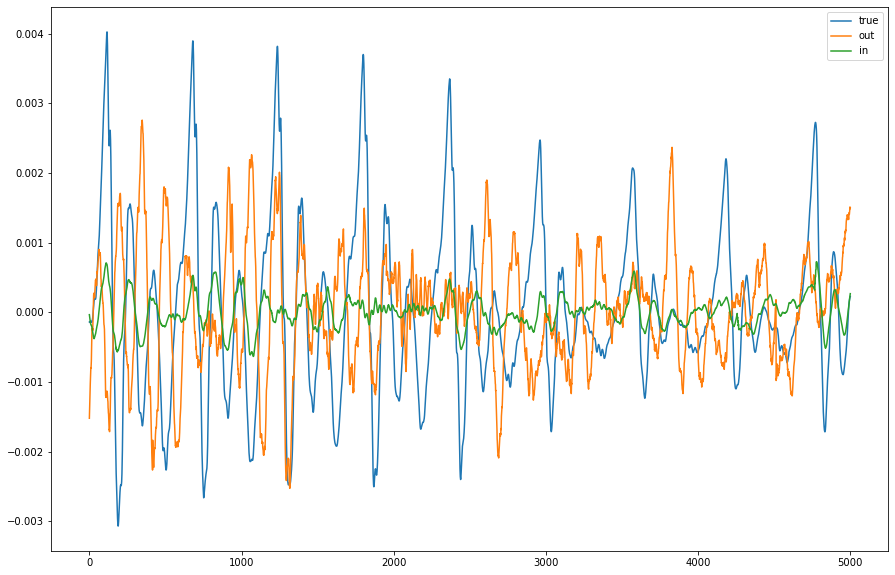

In [90]:
sl = slice(60000, 65000)
plt.figure(figsize=(15,10))
plt.plot(x_true.squeeze().cpu()[sl])
plt.plot(x_pred.squeeze().cpu()[sl])

plt.plot(x_noisy.squeeze().cpu()[sl])
plt.legend(["true", "out", "in"])

In [91]:
display(ipd.Audio(x_noisy.squeeze().cpu(), rate=sr));

In [92]:
display(ipd.Audio(x_true.squeeze().cpu(), rate=sr));

In [93]:
display(ipd.Audio(x_pred.squeeze().cpu(), rate=sr));